# AI in data science project
## Kaggle competition: LLM Detect AI generated text
### Ensemble model with simple classifiers

Used codes from kaggle: 

https://www.kaggle.com/code/zulqarnainali/explained-llm-model?fbclid=IwAR24MUE-EWqjAZVU6OTuA982bxC0LxA7F2e3CnDEjFmId8u24ik5fFQmHOg

https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-llm-detect-ai-generate

In [1]:
# Import packages

import numpy as np
import pandas as pd
import os
import gc
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import Dataset
from transformers import PreTrainedTokenizerFast
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

In [36]:
from sklearn.metrics import confusion_matrix



In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv


In [3]:
# Import data

test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
sub = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')
org_train = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
train = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv", sep=',')
train_prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')

## Data understanding

In [4]:
# Train prompts used in the original training dataset
print(train_prompts.info())
train_prompts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     2 non-null      int64 
 1   prompt_name   2 non-null      object
 2   instructions  2 non-null      object
 3   source_text   2 non-null      object
dtypes: int64(1), object(3)
memory usage: 192.0+ bytes
None


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [5]:
# Original training dataset essays
org_train

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


Text(0.5, 1.0, 'Distribution of Generated Text')

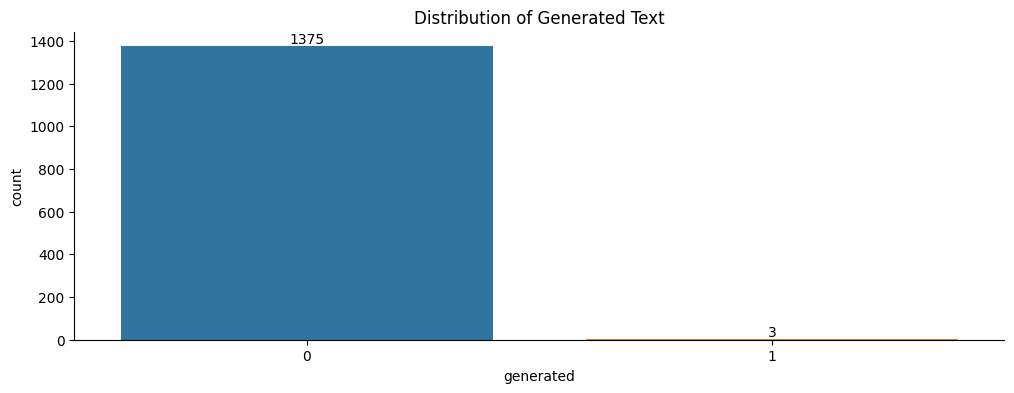

In [6]:
# Distribution of generated - human written essays
f, ax = plt.subplots(figsize=(12, 4))
sns.despine()
ax = sns.countplot(data=org_train, x="generated")

abs_values = org_train['generated'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution of Generated Text")

The external dataset: DAIGT V2

name: train

In [7]:
# Different types of prompt names from the external dataset
train["prompt_name"].unique()

array(['Phones and driving', 'Car-free cities', 'Summer projects',
       '"A Cowboy Who Rode the Waves"',
       'Mandatory extracurricular activities', 'Exploring Venus',
       'Facial action coding system', 'The Face on Mars',
       'Community service', 'Grades for extracurricular activities',
       'Driverless cars', 'Does the electoral college work?',
       'Cell phones at school', 'Distance learning',
       'Seeking multiple opinions'], dtype=object)

In [9]:
# The train dataset
train.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [10]:
# The test dataframe: only contains 3 examples this time
test

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [11]:
# The submission file: format that should be generated at the end
sub

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


<class 'pandas.core.frame.DataFrame'>
Index: 46246 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       46246 non-null  object
 1   generated  46246 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


Text(0.5, 1.0, 'Distribution of Generated Text in all source')

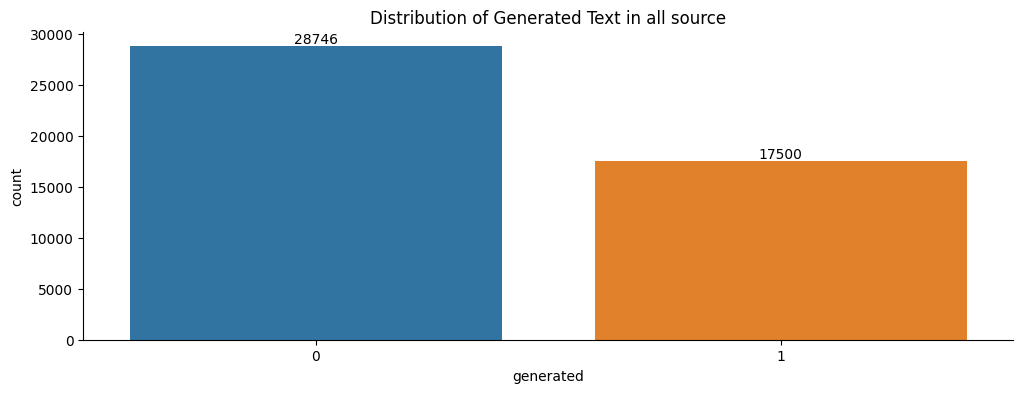

In [18]:
# From now on, we use the train data for model training and validation. 
# First, I need to concatenate the original train data and the external train data.
# The dataframe should contain the following columns: text, prompt ID, label/generated

train.rename(columns = {"label":"generated"}, inplace=True) # rename the label column to generated as in the original data

train_final = pd.concat([train[["text", "generated"]], org_train[["text", "generated"]]])
train_final.info()

f, ax = plt.subplots(figsize=(12, 4))
sns.despine()
ax = sns.countplot(data=train_final,
                   x="generated")
abs_values = train_final['generated'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution of Generated Text in all source")

## Train test split

In [20]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_final["text"],
                                                    train_final["generated"],
                                                    test_size=0.33,
                                                    random_state=42)

## Preprocessing

- tokenization
- TF-IDF vectorization

In [21]:
# Configuration parameters

LOWERCASE = False
VOCAB_SIZE = 30522

In [22]:
# Creating Byte-Pair Encoding tokenizer

raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'generated': y_train}))

def train_corp_iter(): 
    for i in range(0, len(train_dataset), 1000):
        yield train_dataset[i : i + 1000]["text"]
        
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer) # train the tokenizer
tokenizer = PreTrainedTokenizerFast( # creating another tokenizer using the trained tokenizer
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)
tokenized_texts_train = [tokenizer.tokenize(text) for text in tqdm(X_train.tolist())]
tokenized_texts_test = [tokenizer.tokenize(text) for text in tqdm(X_test.tolist())]


#tokenized_texts_test = []
#for text in tqdm(test['text'].tolist()):
#    tokenized_texts_test.append(tokenizer.tokenize(text))
#tokenized_texts_train = []
#for text in tqdm(train['text'].tolist()):
#    tokenized_texts_train.append(tokenizer.tokenize(text))

  0%|          | 0/30984 [00:00<?, ?it/s]

  0%|          | 0/15262 [00:00<?, ?it/s]

In [23]:
tokenized_texts_train[0][:10]
len(tokenized_texts_train)

30984

In [24]:
len(tokenized_texts_test)

15262

In [25]:
# Convert tokenized texts back to sentences
tokenized_texts_train_sentences = [' '.join(tokens) for tokens in tokenized_texts_train]
tokenized_texts_test_sentences = [' '.join(tokens) for tokens in tokenized_texts_test]

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(tokenized_texts_train_sentences)
X_test_tfidf = tfidf_vectorizer.transform(tokenized_texts_test_sentences)

## Model training

In [29]:
# classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
nb_classifier = MultinomialNB(alpha=0.1)
svm_classifier = SVC(kernel='linear', probability=True)  # Note: probability=True for VotingClassifier
sgd_classifier= SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber") 
p6={'n_iter': 2500,
    'verbose': -1,
    'objective': 'cross_entropy',
    'metric': 'auc',
    'learning_rate': 0.01, 
    'colsample_bytree': 0.78,
    'colsample_bynode': 0.8, 
    'lambda_l1': 4.562963348932286, 
    'lambda_l2': 2.97485, 
    'min_data_in_leaf': 115, 
    'max_depth': 23, 
    'max_bin': 898}
lgbm_classifier=LGBMClassifier(**p6)
cat_classifier=CatBoostClassifier(iterations=2000,
                       verbose=0,
                       l2_leaf_reg=6.6591278779517808,
                       learning_rate=0.1,
                       subsample = 0.4,
                       allow_const_label=True,loss_function = 'CrossEntropy')


ensemble_classifier = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('nb', nb_classifier),
    ('svm', svm_classifier),
    ('sgd', sgd_classifier),
    ('lgbm',lgbm_classifier), 
    ('cat', cat_classifier)    
], voting='soft', n_jobs=1)  # 'soft' for probability voting

# pipeline for the ensemble classifier
ensemble_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('ensemble', ensemble_classifier)
])

In [30]:
# train the model
ensemble_pipeline.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=4.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.562963348932286
[LightGBM] [Warning] lambda_l2 is set=2.97485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.97485
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] num_iterations is set=2500, n_iter=2500 will be ignored. Current value: num_iterations=2500


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('ensemble',
                 VotingClassifier(estimators=[('rf',
                                               RandomForestClassifier(random_state=42)),
                                              ('nb', MultinomialNB(alpha=0.1)),
                                              ('svm',
                                               SVC(kernel='linear',
                                                   probability=True)),
                                              ('sgd',
                                               SGDClassifier(loss='modified_huber',
                                                             max_iter=8000,
                                                             tol=0.0001)),
                                              ('lgbm',
                                               LGBMClassifier(colsample_bynode=0.8,
                                                              colsample_bytree=0.78,
                                                              lambda_l1=4.562963348932286,
                                                              lambda_l2=2.97485,
                                                              learning_rate=0.01,
                                                              max_bin=898,
                                                              max_depth=23,
                                                              metric='auc',
                                                              min_data_in_leaf=115,
                                                              n_iter=2500,
                                                              objective='cross_entropy',
                                                              verbose=-1)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x7b0b878ab940>)],
                                  n_jobs=1, voting='soft'))])

In [31]:
# predictions
ensemble_predictions = ensemble_pipeline.predict(X_test)

In [32]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, ensemble_predictions)
classification_report_str = classification_report(y_test, ensemble_predictions)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report_str)

Accuracy: 0.9938409120691915
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9548
           1       1.00      0.99      0.99      5714

    accuracy                           0.99     15262
   macro avg       0.99      0.99      0.99     15262
weighted avg       0.99      0.99      0.99     15262



In [33]:
ensemble_predictions

array([0, 0, 1, ..., 0, 0, 0])

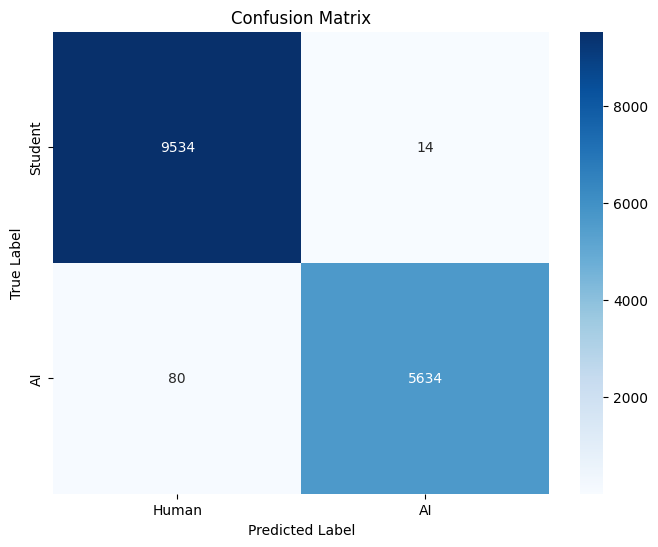

In [37]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, ensemble_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Student', 'AI'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()